# Problem 1

In [27]:
import math
import numpy as np
import kplr
import my_transit
from scipy import integrate
import scipy
import matplotlib.pyplot as plt

In [28]:
# Find the target KOI.
client = kplr.API()
koi = client.koi(97.01)

# Get a list of light curve datasets.
lcs = koi.get_light_curves(short_cadence=False)

# Open the first dataset and read it
f = lcs[0].open()
hdu_data = f[1].data
time = hdu_data["time"]  # get the time of each observation
flux = hdu_data["sap_flux"] # get the flux
flux_err = hdu_data["sap_flux_err"] # get the error in the flux
f.close()

#Extract data in time range 124 < t < 125
extracted_data = np.where((time > 124) & (time < 125))
time_extracted = time[extracted_data]
flux_extracted = flux[extracted_data]
flux_err_extracted = flux_err[extracted_data]

In [29]:
#Function to get the average flux excluding transit

def avg_flux_no_transit(flux_data,iterations,max_iterations, mean, std):
    flux_avg_prime = mean
    flux_std_prime = std
    while (iterations < max_iterations):
        new_list = []
        for f in flux_data:
            if (((abs(f-flux_avg_prime))/flux_std_prime) >= 2):
                new_list.append(f)
        new_array = np.asarray(new_list)
        flux_avg_prime = np.mean(new_list)
        flux_std_prime = np.std(new_list)
        iterations = iterations + 1
    return flux_avg_prime  

In [30]:
#Compute average flux value

flux_mean = np.mean(flux_extracted)
flux_std = np.std(flux_extracted)

flux_avg = avg_flux_no_transit(flux_extracted,0,10,flux_mean,flux_std)
print(flux_avg)

104175.0


In [31]:
#Function to normalize values in array by mean

def normalize(array,avg):
    new_list = []
    for i in array:
        i = i/avg
        new_list.append(i)
    return new_list

In [32]:
#Compute normalized values for flux and flux error

normalized_flux = normalize(flux_extracted,flux_avg)
normalized_flux_err = normalize(flux_err_extracted,flux_avg)

In [33]:
#Function to integrate to get ratio of obscured to unobscured flux

def I(r):
    '''A Limb-darkening function'''
    mu = (1 - (r**2))**(0.5)
    return 1 - (1 - (mu**(0.5)))

def func1(r, p, z):
    return I(r) * (1 - my_transit.delta(p,r,abs(z))) * 2 * r

def func2(r, p, z):
    return I(r) * 2 * r

In [34]:
#Integrate functions above

def flux_fit(p,tao,t0,time_extracted):
    flux_fit_list = []
    for t in time_extracted:
        z = (t - t0)/tao
        numerator,err = integrate.quad(func1,0,1,args=(p,z))
        denominator,err = integrate.quad(func2,0,1,args=(p,z))
        flux_ratio = numerator/denominator
        flux_fit_list.append(flux_ratio)
    return flux_fit_list

In [35]:
#Calculate the value of chi squared

def chi_squared(p,tao,t0,time_extracted,normalized_flux,normalized_flux_err):
    chi_squared = 0
    flux_fit_list = flux_fit(p,tao,t0,time_extracted)
    for i in range(len(normalized_flux)):
        new_value = ((normalized_flux[i] - flux_fit_list[i])/normalized_flux_err[i])**2
        chi_squared = chi_squared + new_value
    return chi_squared

In [36]:
flux_fit_result = flux_fit(0.0775,0.1,124.51,time_extracted)
print(flux_fit_result)
chi_squared_result = chi_squared(0.0775,0.1,124.51,time_extracted,normalized_flux,normalized_flux_err)
print(chi_squared_result)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9949034157565049, 0.9935721741229445, 0.9929594919964251, 0.9926370108372341, 0.9925054702381426, 0.9925354869557282, 0.9927333494118622, 0.9931472126775782, 0.9939355230653127, 0.9966752058021856, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
475.062124482


# Problem 2

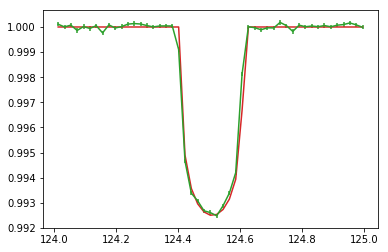

In [37]:
#Plot the fit of the flux that we got from Problem 1

plt.errorbar(time_extracted, normalized_flux,normalized_flux_err)
plt.plot(time_extracted,flux_fit_result)
plt.show()

This is not a good fit because some of the points on the fit of the flux (in orange) are not within the errorbars of the points on the calculated flux curve (in blue).

In [38]:
#Find the degrees of freedom

def deg_freedom(data,m):
    n = len(data)
    v = n - m
    return v

v = deg_freedom(time_extracted,3)
print(v)

46


In [39]:
#Find the probability of getting this chi squared value

p = (scipy.special.gammaincc(v/2,chi_squared_result/2))
print(p)

1.2550465015e-72


This p-value confirms that this is not a good fit, as the p-value is extremely low, meaning that there is a very low chance of getting the calculated chi squared value.

# Problem 3

In [40]:
#Varying tao parameter

tao = 0.08
chi_squared_results = []
while tao <= 0.13:
    chi_squared_result_new = chi_squared(0.0775,tao,124.51,time_extracted,normalized_flux,normalized_flux_err)
    chi_squared_results.append([tao,chi_squared_result_new])
    tao = tao + 0.001
    
print(chi_squared_results)

[[0.08, 5243.0716203067122], [0.081, 5035.6616524797191], [0.082, 4892.471570673566], [0.083, 4638.9948063456104], [0.084, 4277.4651974538074], [0.085, 3854.3342656519517], [0.08600000000000001, 3403.2037520121507], [0.08700000000000001, 2950.4307359935642], [0.08800000000000001, 2516.5687898265292], [0.08900000000000001, 2116.6356278489047], [0.09000000000000001, 1719.359973749157], [0.09100000000000001, 1334.8564519280562], [0.09200000000000001, 989.37909361830157], [0.09300000000000001, 699.8735000156596], [0.09400000000000001, 477.00512322418012], [0.09500000000000001, 326.23608007056424], [0.09600000000000002, 251.18135591221773], [0.09700000000000002, 236.83630144852697], [0.09800000000000002, 272.45252179316981], [0.09900000000000002, 353.69642479349289], [0.10000000000000002, 475.06212448162466], [0.10100000000000002, 627.32305869526544], [0.10200000000000002, 783.28954745445435], [0.10300000000000002, 936.40475590633355], [0.10400000000000002, 1071.0451347305225], [0.105000000

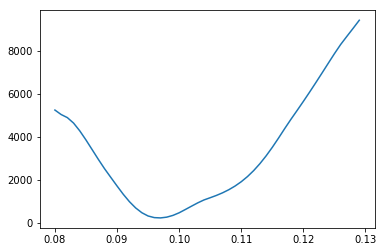

In [44]:
#Plot tao vs. chi squared

tao_list = []
chi_squared_list = []
for r in chi_squared_results:
    tao_list.append(r[0])
    chi_squared_list.append(r[1])
    
plt.plot(tao_list,chi_squared_list)
plt.show()

In [45]:
#Minimum of chi squared values in this graph

chi_squared_min = math.inf
tao_min = math.inf
for r in chi_squared_results:
    if (r[1] < chi_squared_min):
        chi_squared_min = r[1]
        tao_min = r[0]

print(chi_squared_min)

236.836301449


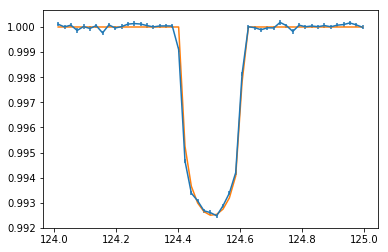

In [21]:
#Flux fit for minimum chi squared value parameters

best_flux_fit_result = flux_fit(0.0775,0.097,124.51,time_extracted)
plt.errorbar(time_extracted,normalized_flux,normalized_flux_err)
plt.plot(time_extracted,best_flux_fit_result)
plt.show()

In [46]:
#Find p value for minimum chi squared value parameters

p = (scipy.special.gammaincc(v/2,chi_squared_min/2))
print(p)

1.67627023319e-27


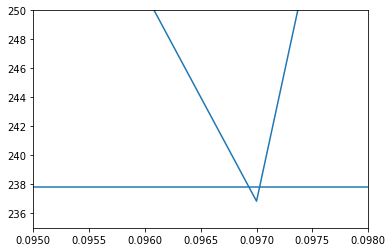

In [63]:
#One sigma uncertainty in this parameter

chi_squared_w_uncertainty = chi_squared_min + 1
plt.axhline(y = chi_squared_w_uncertainty)
plt.plot(tao_list,chi_squared_list)
plt.axis([0.095,0.098,235,250])
plt.show()

From the graph above, we can see that when we add a one-sigma uncertainty in the chi squared parameter, there are two corresponding tao values. These tao values are about 0.0001 away from the original tao value of 0.097.

# Problem 4

In [21]:
tao = 0.09
p = 0.06
t0 = 124
chi_squared_results_w_parameters = []
chi_squared_results_only = []
while tao <= 0.11:
    while p <= 0.08:
        while t0 <= 125:
            chi_squared_result_new = chi_squared(p,tao,t0,time_extracted,normalized_flux,normalized_flux_err)
            chi_squared_results_w_parameters.append([tao,p,t0,chi_squared_result_new])
            chi_squared_results_only.append(chi_squared_result_new)
            t0 = t0 + 0.1
        t0 = 124
        p = p + 0.01
    p = 0.06
    tao = tao + 0.01

min_chi = math.inf
for chi in chi_squared_results_only:
    if (chi < min_chi):
        min_chi = chi
print(min_chi)

best_tao = 0
best_p = 0
best_t0 = 0
for results in chi_squared_results_w_parameters:
    if (results[3] == min_chi):
        best_tao = results[0]
        best_p = results[1]
        best_t0 = results[2]
print(best_tao,best_p,best_t0)
         
        

1171.26928452
0.09999999999999999 0.07999999999999999 124.49999999999997


The best fit parameters are when tao = 0.1, p = 0.08, and t0 = 124.5. The uncertainty for tao is 0.01, the uncertainty for p is 0.001, and the uncertainty for t0 is 0.01. These uncertainties are based on the imprecision that comes from addition on Python.